<a href="https://colab.research.google.com/github/IzmailovRuslan/super-duper-giggle/blob/main/Autoencoders%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder

## 1.1. Подготовка данных


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
import os
import pandas as pd
import skimage.io
from skimage.transform import resize

In [ ]:
# Два датасета: картинки и их аттрибуты (описания)
data, attrs = fetch_dataset()

In [ ]:
# Нормировка 
for i, ph in enumerate(data):
  ph = (ph - ph.min()) / (ph.max() - ph.min())
  data[i]=ph

Разбиение картинок на train и val, приведение к тензорам pytorch

In [ ]:
from sklearn.model_selection import train_test_split
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

## 1.2. Архитектура модели 
Классический автоэнкодер



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">



In [ ]:
dim_code = 64 #размер латентного вектора

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.flatten = nn.Flatten()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=12288, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=dim_code)

        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=12288)
        )
        
    def forward(self, x):
        # encoding
        x = self.flatten(x).float()
        latent_code = self.encoder(x)

        # decoding
        x = self.decoder(latent_code)
        reconstruction = torch.sigmoid(x)
        
        return reconstruction, latent_code

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
criterion = F.mse_loss

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

## 1.3 Обучение

In [ ]:
import seaborn as sns

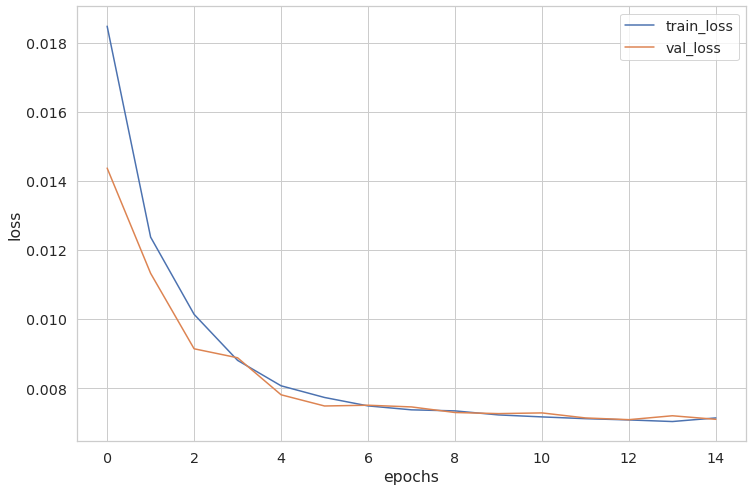

In [ ]:
n_epochs = 15
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, latent_code = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(batch.to(device).float(), reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          reconstruction, latent_code = autoencoder(batch.to(device))
          reconstruction = reconstruction.view(-1, 64, 64, 3)
          loss = criterion(batch.to(device).float(), reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

    clear_output()
    sns.set(style="whitegrid", font_scale=1.3)
    plt.figure(figsize=(12, 8))
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

Посмотрим, как тренированный автоэнкодер кодирует и восстанавливает картинки:

In [ ]:
autoencoder.eval()
with torch.no_grad():
      for batch in val_loader:
        reconstruction, latent_code = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.numpy()
        break

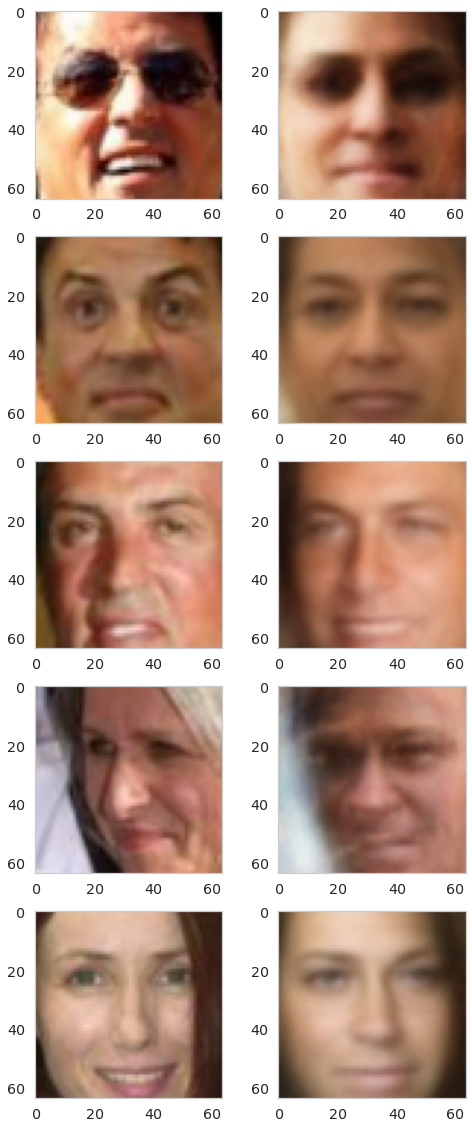

In [ ]:
import matplotlib.pyplot as plt
sns.set_style("whitegrid", {'axes.grid' : False})

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res)

## 1.4. Sampling 

Теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создавать новые картинки.

Передадим декодеру сгенерированные векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. Чтобы получались лица при передаче вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фотографий.

In [ ]:
# сгенерируем 20 рандомных векторов размера latent_space

z = np.random.randn(20, dim_code)
output = torch.sigmoid(autoencoder.decoder(torch.Tensor(z)))
output = output.view(-1, 64, 64, 3)
output = output.cpu().detach().numpy()

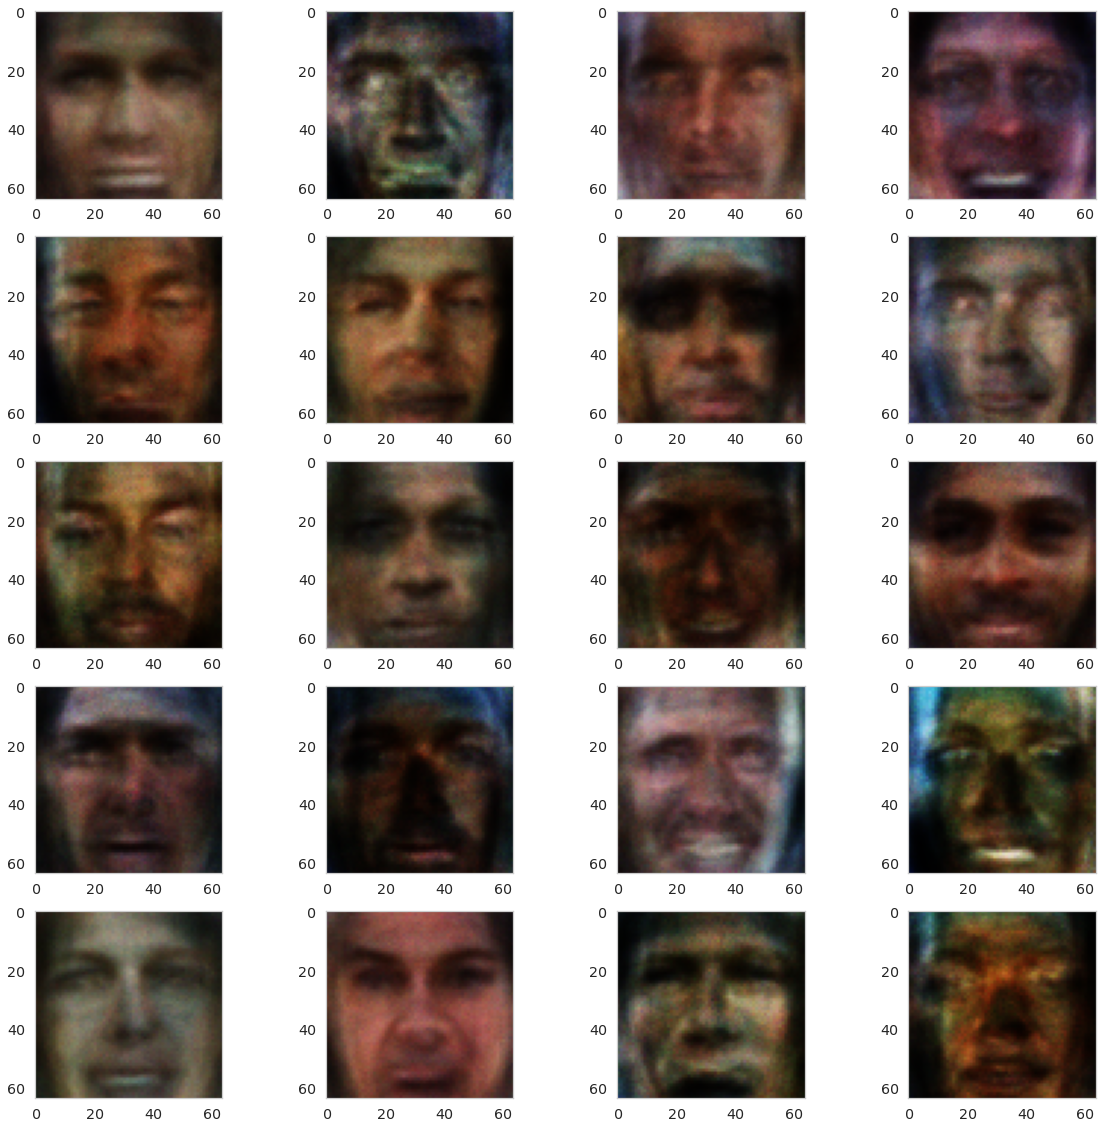

In [ ]:
plt.figure(figsize=(20, 20))
i = 0
j = 1
while i < len(output):
  plt.subplot(5, 4, j)
  plt.imshow(output[i])
  plt.subplot(5, 4, j+1)
  plt.imshow(output[i+1])
  plt.subplot(5, 4, j+2)
  plt.imshow(output[i+2])
  plt.subplot(5, 4, j+3)
  plt.imshow(output[i+3])
  i += 4
  j += 4

## Time to make fun!

Научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. Теперь добавим улыбку грустному человеку: сложим полученный в пункте 3 вектор с латентным вектором грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
# Берем индексы обычных и улыбающихся людей
smiling_ids = attrs.sort_values(['Smiling']).tail(10).index
sad_ids = attrs.sort_values(['Smiling']).head(10).index

In [ ]:
# Отдаем энкодеру и получаем латентные вектора
smile_data = torch.FloatTensor(data[smiling_ids]).to(device)
sad_data = torch.FloatTensor(data[sad_ids]).to(device)

In [ ]:
reconstruction, latent_code_smiling = autoencoder(smile_data)

In [ ]:
reconstruction, latent_code_sad = autoencoder(sad_data)

In [ ]:
# Находим вектор улыбки 
smile_vector = latent_code_smiling.mean(axis = 0) - latent_code_sad.mean(axis = 0) 

In [ ]:
# Добавим всем грустным людям улыбку
latent_code_sad_updated = latent_code_sad + 0.5*smile_vector

In [ ]:
# Прогоним через декодер
res = torch.sigmoid(autoencoder.decoder(latent_code_sad_updated))
res = res.view(-1, 64, 64, 3)
res = res.cpu().detach().numpy()

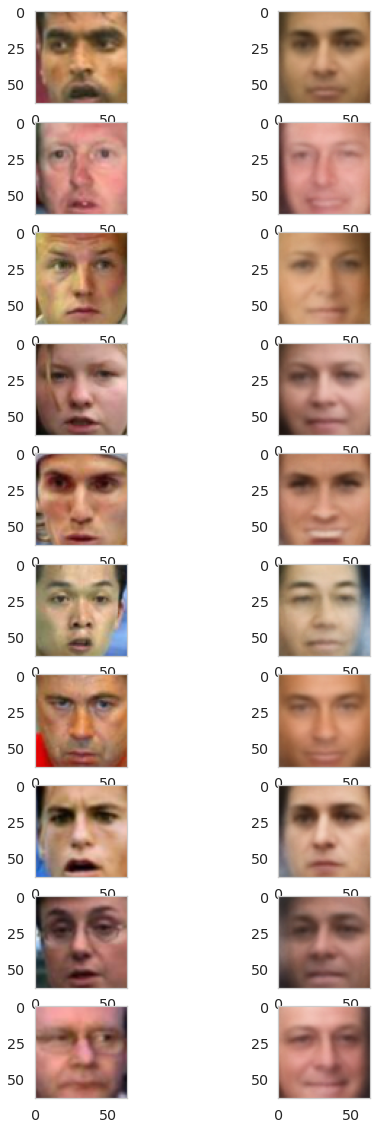

In [ ]:
# Нарисуем
plt.figure(figsize=(8, 20))
i, j = 0, 1

while i <10:
  plt.subplot(10, 2, j)
  plt.imshow(data[sad_ids][i])
  plt.subplot(10, 2, j+1)
  plt.imshow(res[i])
  j += 2
  i += 1

Улыбка другу)))

In [ ]:
from PIL import Image

In [ ]:
image =  Image.open('/content/ilya.jpg')  # Открывает и идентифицирует файл изображения
image.load()  # Выделяет память для изображения и загружает данные пикселей в память 
image = image.resize((64, 64))
image = np.array(image)

In [ ]:
sad_img = torch.FloatTensor(image).to(device)
sad_img = (sad_img - sad_img.min()) / (sad_img.max() - sad_img.min())
sad_img = sad_img.view(-1, 64, 64, 3)
reconstruction, latent_code, _, _ = autoencoder(sad_img)
latent_code = latent_code + 0.7*smile_vector

In [ ]:
res = torch.sigmoid(autoencoder.decoder(latent_code))
res = res.view(64, 64, 3)
res = res.cpu().detach().numpy()

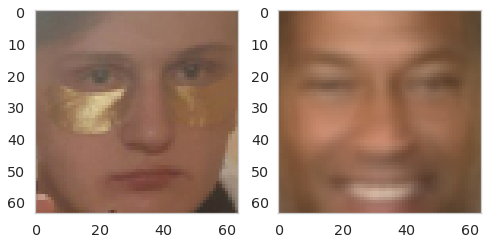

In [ ]:
plt.figure(figsize=(8, 10))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(res)

# Часть 2: Variational Autoencoder

Вариационных автоэнкодеров — улучшенная версии AE

In [ ]:
from torchvision import datasets, transforms

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', transform=transforms.ToTensor(), train=True, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', transform=transforms.ToTensor(), train=False, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение

Реализуем VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (1, 3, 3)),
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=288, out_features=100),
            nn.ReLU(),  
            nn.Linear(in_features=100, out_features=dim_code*2)
        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=288),
            nn.ReLU(),
            nn.Unflatten(1, (32, 3, 3)),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=1),
        )
        
    def encode(self, x):
        # encoding
        x = self.encoder(x).view(-1, 2, dim_code)

        # чтобы генерировать новые изображения, нужно знать распределение в латентном пространстве
        # для этого явно скажем, что латентные вектора имеют нормальное распределение с какими-то параметрами mu и sigma 
        # тогда энкодер выдает не точку, а параметры этого распределения
        # мы хотим генерировать данные из стандартного нормального распределения (mu=0 и sigma=1)
        # для перехода между распределениями выполняется reparameterization trick
        # для этого нужны `mu` и `log_var` - параметры латентного пространства энкодера, именно их мы и будем обучать
        mu = x[:, 0, :] # примем первое число в паре за среднее
        log_var = x[:, 1, :] # второе за логарифм дисперсии   
        return mu, log_var
        
    
    def gaussian_sampler(self, mu, log_var):
        if self.training:
            # получение латентного вектора путем репараметризации
            std = torch.exp(0.5 * log_var) # стандартное отклонение из латентного пространства
            eps = torch.randn_like(std) # случайный вектор из стандартного распределения
            latent_code = mu + (eps * std) # сэмплирование вектора из произвольного распределения 
            return latent_code
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        z = self.decoder(z)
        reconstruction = torch.sigmoid(z)
        
        return reconstruction

    def forward(self, x):
        mu, log_var = self.encode(x)
        latent_code = self.gaussian_sampler(mu, log_var)
        reconstruction = self.decode(latent_code)

        return mu, log_var, reconstruction

Определим лосс и его компоненты для VAE:

Лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu**2 - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
dim_code = 64

criterion = loss_vae

V_autoencoder = VAE()

optimizer = torch.optim.Adam(V_autoencoder.parameters())

In [ ]:
import seaborn as sns

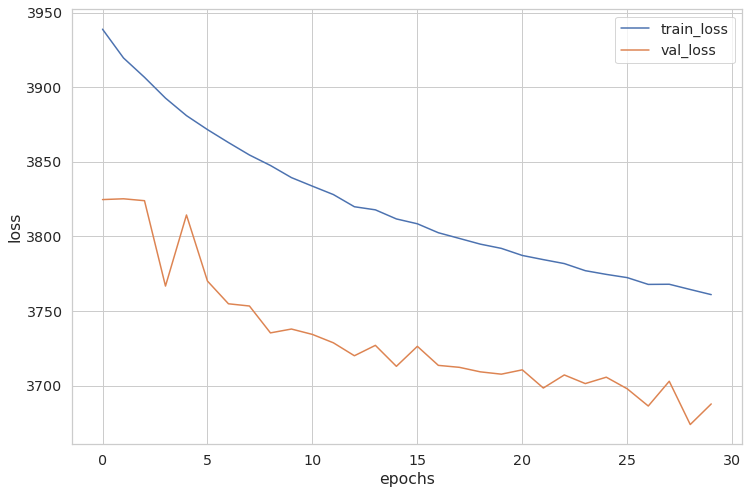

In [ ]:
n_epochs = 30
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    V_autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        mu, logsigma, reconstruction = V_autoencoder(batch[0].to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    V_autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          mu, logsigma, reconstruction = V_autoencoder(batch[0].to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

    clear_output()
    sns.set(style="whitegrid", font_scale=1.3)
    plt.figure(figsize=(12, 8))
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

Посмотрим, как тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
V_autoencoder.eval()
with torch.no_grad():
      for batch in test_loader:
        mu, logsigma, reconstruction = V_autoencoder(batch[0].to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch[0].numpy()
        break

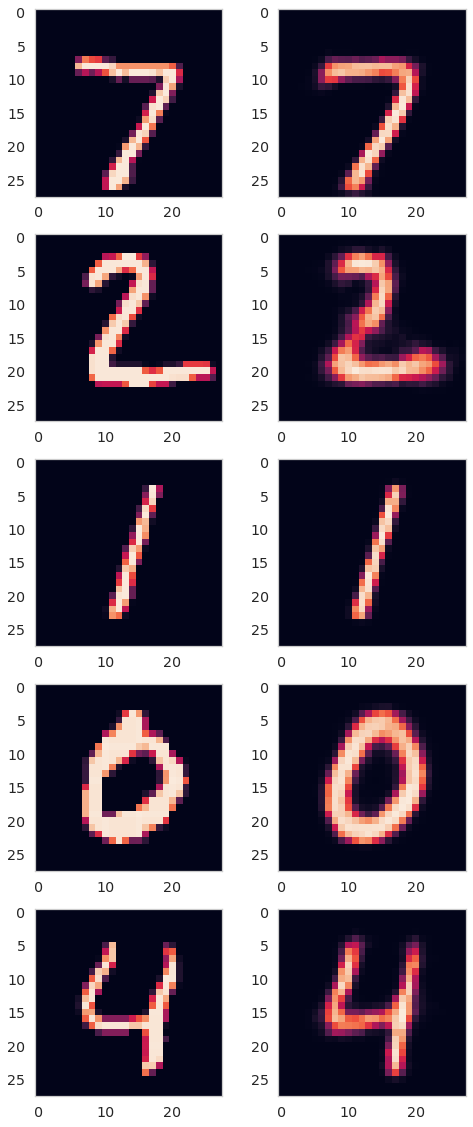

In [ ]:
import matplotlib.pyplot as plt
sns.set_style("whitegrid", {'axes.grid' : False})

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt[0])
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res[0])
  

Передадим decoder'у из VAE случайные векторы из нормального распределения и посмотрим, какие картинки получаются:

In [ ]:
z = np.array([np.random.normal(0, 1, 64) for i in range(12)])
output = torch.sigmoid(V_autoencoder.decoder(torch.Tensor(z)))
output = output.view(-1, 28, 28)
output = output.cpu().detach().numpy()

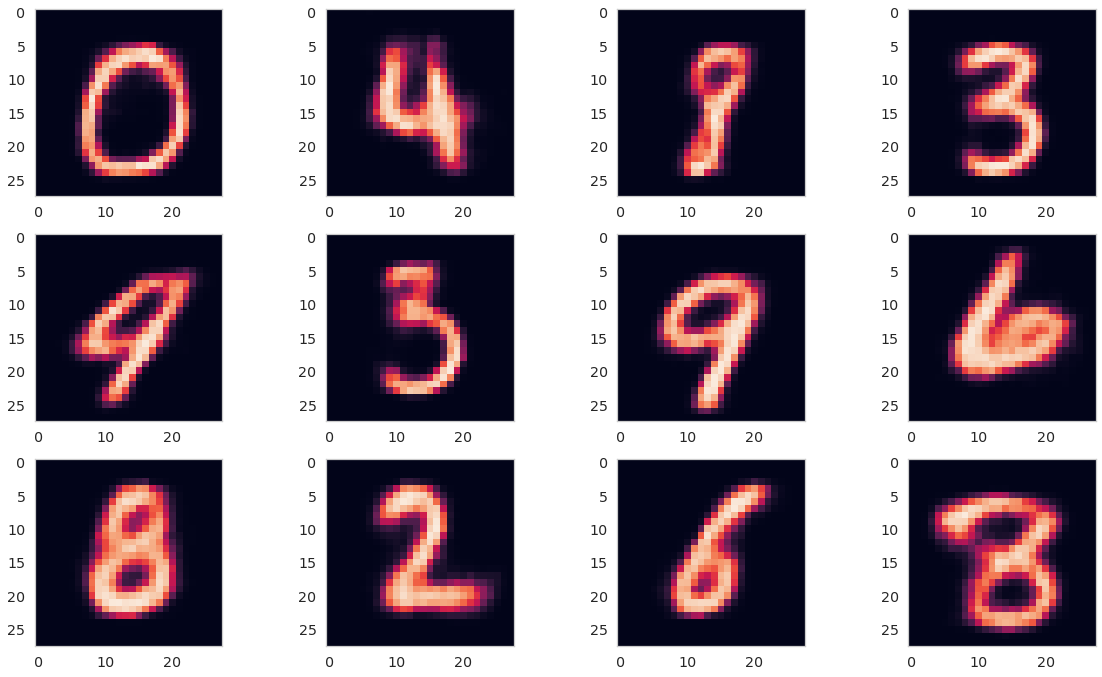

In [ ]:
plt.figure(figsize=(20, 20))
i = 0
j = 1
while i < len(output):
  plt.subplot(5, 4, j)
  plt.imshow(output[i])
  plt.subplot(5, 4, j+1)
  plt.imshow(output[i+1])
  plt.subplot(5, 4, j+2)
  plt.imshow(output[i+2])
  plt.subplot(5, 4, j+3)
  plt.imshow(output[i+3])
  i += 4
  j += 4

## 2.2. Latent Representation

Посмотрим, как выглядяит латентное пространство.
Это позволит оценить, насколько плотно распределены латентные векторы изображений. 

План:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (из `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр (plt.scatter имеет параметр c (color)).

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Получить латентные представления картинок тестового датасета
V_autoencoder.eval()
result = torch.Tensor()
labels = torch.Tensor()
with torch.no_grad():
      for batch in test_loader:
        mu, logsigma, reconstruction = V_autoencoder(batch[0].to(device))
        result = torch.cat([result, mu])
        labels = torch.cat([labels, batch[-1]])

In [ ]:
# С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
result_embedded = TSNE(n_components=2, learning_rate='auto').fit_transform(result)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


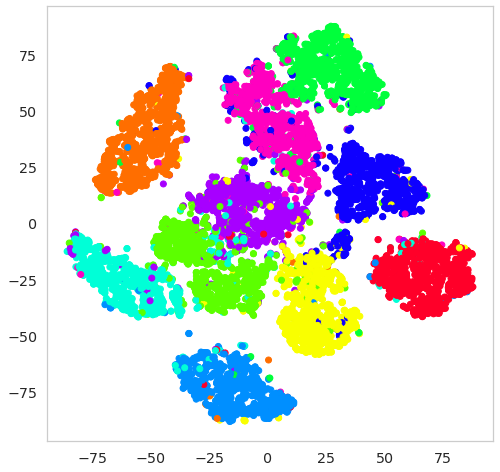

In [ ]:
# Визуализировать полученные двумерные представления с помощью matplotlib.scatter
plt.figure(figsize=(8, 8))
plt.scatter(result_embedded[:, 0], result_embedded[:, 1], c=labels, cmap='gist_rainbow')

Латентное пространство выглядит вполне хорошо разделенным на кластеры

## 2.3. Conditional VAE 


Допустим, есть AE, обученный на датасете MNIST, и мы хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные цифры). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты, но восьмерка никак не генерируется:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов.  Conditional AE — вид автоэнкодера, который предоставляет такую возможность. 

### Архитектура

Единственное отличие от обычного AE -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



In [ ]:
class CVAE(nn.Module):

    def __init__(self):
        super(CVAE, self).__init__()

        self.flatten = nn.Flatten()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=794, out_features=250),
            nn.ReLU(),
            nn.Linear(in_features=250, out_features=dim_code*2)

        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code+10, out_features=250),
            nn.ReLU(),
            nn.Linear(in_features=250, out_features=784)
        )

    def encode(self, x, class_num):
        oh_label = torch.zeros(x.shape[0], 10).to(device)
        for i in range(x.shape[0]):
            oh_label[i][int(class_num[i])] = 1


        x = self.flatten(x).float()
        x = self.encoder(torch.cat((x, oh_label), dim=1)).view(-1, 2, dim_code)
        mu = x[:, 0, :] 
        log_var = x[:, 1, :] 
        return mu, log_var

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) 
            eps = torch.randn_like(std) 
            latent_code = mu + (eps * std) 
            return latent_code
        else:
            return mu
    
    def decode(self, z, class_num):
        oh_label = torch.zeros(z.shape[0], 10).to(device)
        for i in range(z.shape[0]):
            oh_label[i][int(class_num[i])] = 1

        z = self.decoder(torch.cat((z, oh_label), dim = 1))
        reconstruction = torch.sigmoid(z)
        
        return reconstruction
        
    def forward(self, x, label):
        mu, log_var = self.encode(x, label)
        latent_code = self.gaussian_sampler(mu, log_var)
        reconstruction = self.decode(latent_code, label)

        return mu, log_var, reconstruction

In [ ]:
dim_code = 64

criterion = loss_vae

CV_autoencoder = CVAE()

optimizer = torch.optim.Adam(CV_autoencoder.parameters())

In [ ]:
import seaborn as sns

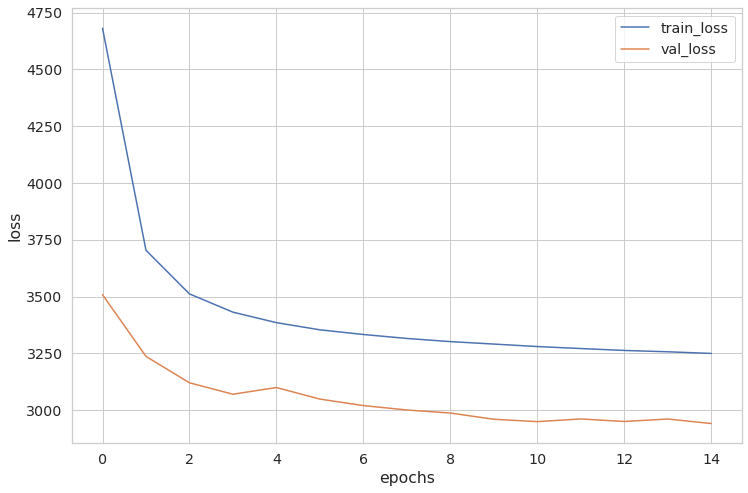

In [ ]:
n_epochs = 15
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    CV_autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        mu, logsigma, reconstruction = CV_autoencoder(batch[0].to(device), batch[1].to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    CV_autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          mu, logsigma, reconstruction = CV_autoencoder(batch[0].to(device), batch[1].to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

    clear_output()
    sns.set(style="whitegrid", font_scale=1.3)
    plt.figure(figsize=(12, 8))
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

### Sampling


Попробуем сэмплировать из CVAE. Можно взять один латентный вектор и попросить CVAE восстановить из него картинки разных классов!

In [ ]:
z = np.random.randn(1, dim_code)

In [ ]:
ims = [[]]
# сэмплируем цифры от 0 до 9 на основе одного и того же латентного вектора
for i in range(10):
  output = torch.sigmoid(CV_autoencoder.decode(torch.Tensor(z), [i]))
  output = output.view(28, 28)
  output = output.cpu().detach().numpy()
  ims.append(output)

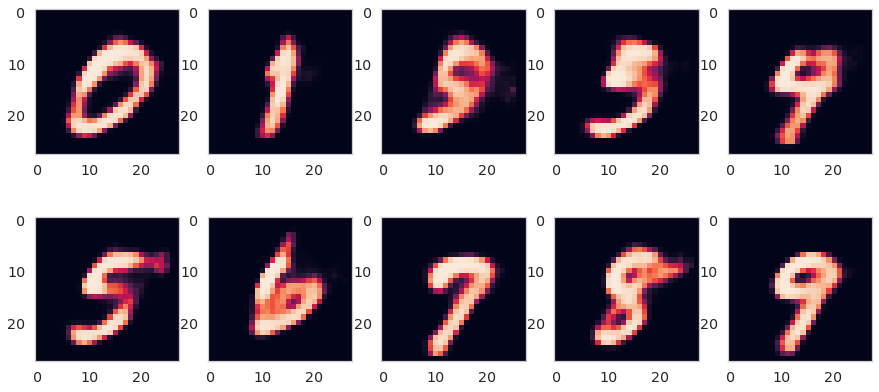

In [ ]:
plt.figure(figsize=(15, 7))
sns.set_style("whitegrid", {'axes.grid' : False})
for i in range(1, 11):
  plt.subplot(2, 5, i)
  plt.imshow(ims[i])

### Latent Representations

Посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE

In [ ]:
# Получить латентные представления картинок тестового датасета
CV_autoencoder.eval()
result = torch.Tensor()
labels = torch.Tensor()
with torch.no_grad():
      for batch in test_loader:
        mu, logsigma, reconstruction = CV_autoencoder(batch[0].to(device), batch[1].to(device))
        result = torch.cat([result, mu])
        labels = torch.cat([labels, batch[-1]])

In [ ]:
# С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
result_embedded = TSNE(n_components=2, learning_rate='auto').fit_transform(result)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


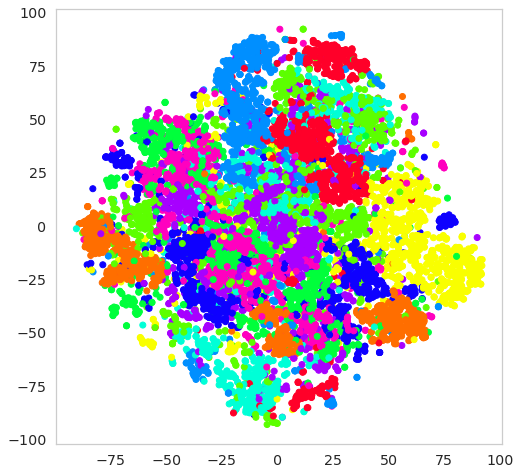

In [ ]:
# Визуализировать полученные двумерные представления с помощью matplotlib.scatter
plt.figure(figsize=(8, 8))
plt.scatter(result_embedded[:, 0], result_embedded[:, 1], c=labels, cmap='gist_rainbow')

Здесь кластеры не разделены, правильнее сказать - перемешаны. Это позволяет плавно переходить от сэмплирования одной цифры к другой.